# Linear Regression Model

In [245]:
from datetime import datetime, timedelta
## Data Loading
from pathlib import Path
from typing import Callable

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numpy import deg2rad
from pandas import DataFrame
from pytz import timezone
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from solarpy import standard2solar_time, irradiance_on_plane, beam_irradiance
from spherical_coordinates import az_zd_to_cx_cy_cz

# Root directory for datasets
DATASETS_ROOT = '../data/data-1'

SYSTEM_ID = '4708'
AZIMUTHS = [90, 270]
ELEVATIONS = [30, 30]
AREA_FRACTIONS = [0.5, 0.5]
LATITUDE = 51.8144
LONGITUDE = -0.2949
ALTITUDE = 0

UKTZ = timezone('Europe/London')
UTC = timezone('UTC')

# Set dark mode style for all plots
plt.style.use('dark_background')

# OPENMETEO_FORECAST_MODEL = 'best_match'
# OPENMETEO_FORECAST_MODEL = 'metno_seamless'
# OPENMETEO_FORECAST_MODEL = 'icon_seamless'
OPENMETEO_FORECAST_MODEL = 'ukmo_seamless'
OPENMETEO_FIELDS = [
    'direct_normal_irradiance',
    'diffuse_radiation',
    'temperature_2m',
    'cloud_cover',
]

PVOUTPUT_FIELDS = ['energy', 'average']


def load_data(
        file_path: str, datetime_extractor: Callable[[DataFrame], datetime], fields: list[str],
        suffix: str | None = None, renamer: dict[str, str] = None,
) -> pd.DataFrame:
    df = pd.read_csv(Path(DATASETS_ROOT, file_path))
    df['datetime'] = datetime_extractor(df)
    if suffix:
        suffixed_fields = [
            f"{field}_{suffix}" for field in fields
        ]
        df.rename(columns=dict(zip(suffixed_fields, fields)), inplace=True)

    df = df[['datetime', *fields]]

    if renamer:
        df.rename(columns=renamer, inplace=True)
    return df


weather_qhourly = load_data(
    f'openmeteo-quarterhourly_{SYSTEM_ID}.csv',
    lambda df: pd.to_datetime(df['time']),
    OPENMETEO_FIELDS,
    suffix=OPENMETEO_FORECAST_MODEL,
)

weather_hourly = load_data(
    f'openmeteo-historical_{SYSTEM_ID}.csv',
    lambda df: pd.to_datetime(df['time']),
    OPENMETEO_FIELDS,
    suffix=OPENMETEO_FORECAST_MODEL,
)

weather = pd.concat([weather_hourly, weather_qhourly]).drop_duplicates('datetime').sort_values('datetime').reset_index(
    drop=True)

pv = load_data(
    f'pvoutput_{SYSTEM_ID}.csv',
    lambda df: pd.to_datetime(df['date'].astype(str) + 'T' + df['time']),
    PVOUTPUT_FIELDS,
    renamer={'average': 'power'},
)


def verify_average_powers() -> None:
    power_computed = pv['energy'].diff() * 3600 / pv['datetime'].diff().dt.total_seconds()
    mask = power_computed.notna() & pv['power'].notna()
    max_error = max(power_computed[mask] - pv['power'][mask])
    assert max_error == 0, f'Max error: {max_error}'


verify_average_powers()

weather['blue_sky_index'] = 1 - weather['cloud_cover'] / 100
weather.drop('cloud_cover', axis=1, inplace=True)

joined = pv.join(weather.set_index('datetime'), on='datetime', how='inner')
joined.dropna(inplace=True)


def calc_v_norm(az, el):
    cx_cy_cz = az_zd_to_cx_cy_cz(deg2rad(az), deg2rad(el))
    return cx_cy_cz[0], cx_cy_cz[1], -cx_cy_cz[2]


v_norms = [
    calc_v_norm(az, el) for az, el in zip(AZIMUTHS, ELEVATIONS)
]


def to_utc(dt_local):
    return UKTZ.localize(dt_local).astimezone(UTC)


# Lookup table: blue_sky_index -> irradiance_factor
BLUE_SKY_INDEX_TABLE = np.array([0.0, 0.5, 1.0])
IRRADIANCE_FACTOR_TABLE = np.array([0.2, 0.7, 1.0])


def modified_by_blue_sky_index(func):
    """Decorator that modifies irradiance calculation based on blue sky index."""

    def wrapper(dt: datetime, blue_sky_index: float) -> float:
        irradiance = func(dt)
        # Linear interpolation between table values
        irradiance_factor = np.interp(blue_sky_index, BLUE_SKY_INDEX_TABLE, IRRADIANCE_FACTOR_TABLE)
        return irradiance * irradiance_factor

    return wrapper


@modified_by_blue_sky_index
def calculate_irradiance_on_panels(dt: datetime) -> float:
    solar_time = standard2solar_time(to_utc(dt), LONGITUDE)

    irradiances_per_panel_group = [
        max(0., irradiance_on_plane(v_norm, ALTITUDE, solar_time, LATITUDE)) * area_frac
        for v_norm, area_frac in zip(v_norms, AREA_FRACTIONS)
    ]
    return sum(irradiances_per_panel_group)


@modified_by_blue_sky_index
def calculate_direct_normal_irradiance(dt: datetime) -> float:
    solar_time = standard2solar_time(to_utc(dt), LONGITUDE)
    return max(0., beam_irradiance(ALTITUDE, solar_time, LATITUDE))


joined['calculated_irradiance_on_panels'] = joined.apply(
    lambda row: calculate_irradiance_on_panels(row['datetime'], row['blue_sky_index']), axis=1
)

joined['calculated_direct_normal_irradiance'] = joined.apply(
    lambda row: calculate_direct_normal_irradiance(row['datetime'], row['blue_sky_index']), axis=1
)

X, y = train_test_split(joined, test_size=0.2, random_state=42)
X.sort_index(inplace=True)

# X = X[X['blue_sky_index'] == 1.0]
# X = X[X['datetime'] >= pd.to_datetime('2025-06-01')]

# X.head(n=30)


## Plotting Results

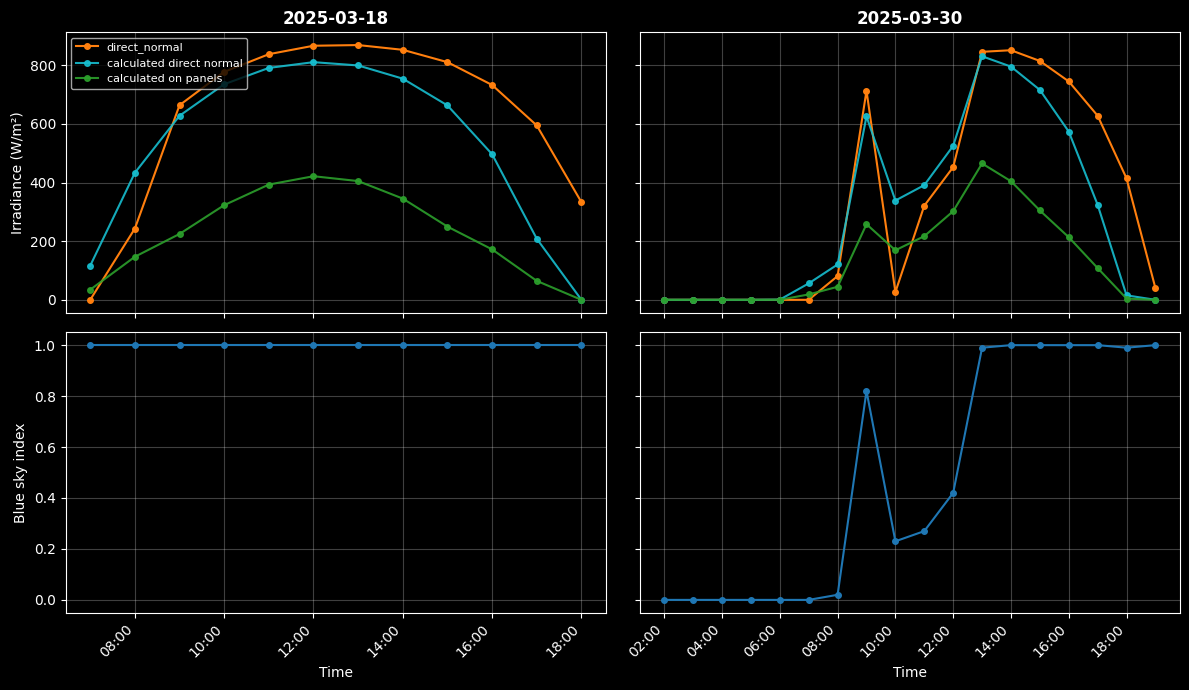

,datetime,energy,power,direct_normal_irradiance,diffuse_radiation,temperature_2m,blue_sky_index,calculated_irradiance_on_panels,calculated_direct_normal_irradiance
21982,2025-03-30 02:00:00,0,0.0,0.0,0.0,9.9,0.00,0.000000,0.000000
21988,2025-03-30 03:00:00,0,0.0,0.0,0.0,10.2,0.00,0.000000,0.000000
21994,2025-03-30 04:00:00,0,0.0,0.0,0.0,10.0,0.00,0.000000,0.000000
22000,2025-03-30 05:00:00,0,0.0,0.0,0.0,9.7,0.00,0.000000,0.000000
22006,2025-03-30 06:00:00,0,0.0,0.0,0.0,9.1,0.00,0.174667,0.658072
22012,2025-03-30 07:00:00,9,48.0,0.0,8.0,8.7,0.00,18.341300,56.028940
22018,2025-03-30 08:00:00,358,540.0,81.0,61.0,9.2,0.02,44.414755,120.568033
22024,2025-03-30 09:00:00,1089,792.0,713.2,56.0,10.0,0.82,258.031692,625.693076
22030,2025-03-30 10:00:00,2350,1176.0,26.4,265.0,10.5,0.23,169.074290,338.663872
22036,2025-03-30 11:00:00,3898,1686.0,321.1,270.0,11.7,0.27,217.071537,391.212966


In [256]:
from matplotlib.dates import DateFormatter, AutoDateLocator

days_of_interest = [
    # '2025-03-18',
    # '2025-05-10',
    # '2025-04-07',
    # '2025-08-25',

    '2025-03-18',
    # '2025-03-29',
    '2025-03-30',
    # '2025-03-31',
]

# Create 2-by-N grid
n_days = len(days_of_interest)
fig, axes = plt.subplots(2, n_days, figsize=(6 * n_days, 7), sharex='col', sharey='row')
import matplotlib.pyplot as plt

for col, date_str in enumerate(days_of_interest):
    # Filter data for this day
    start = pd.to_datetime(date_str)
    end = start + pd.Timedelta(days=1)
    mask = (joined['datetime'] >= start) & (joined['datetime'] < end)
    sub = joined.loc[mask].sort_values('datetime').reset_index(drop=True)

    # Top row: irradiance plots
    ax_top = axes[0, col]
    ax_top.plot(sub['datetime'], sub['direct_normal_irradiance'],
                label='direct_normal', color='tab:orange', marker='o', linestyle='-', markersize=4)
    ax_top.plot(sub['datetime'], sub['calculated_direct_normal_irradiance'],
                label='calculated direct normal', color='tab:cyan', alpha=0.9, marker='o', linestyle='-', markersize=4)
    ax_top.plot(sub['datetime'], sub['calculated_irradiance_on_panels'],
                label='calculated on panels', color='tab:green', alpha=0.9, marker='o', linestyle='-', markersize=4)
    ax_top.set_title(date_str, fontsize=12, fontweight='bold')
    ax_top.grid(alpha=0.25)

    # Only show y-label on leftmost plot
    if col == 0:
        ax_top.set_ylabel('Irradiance (W/m²)')
        ax_top.legend(loc='upper left', fontsize=8)

    # Bottom row: blue sky index
    ax_bottom = axes[1, col]
    ax_bottom.plot(sub['datetime'], sub['blue_sky_index'],
                   marker='o', label='blue_sky_index', color='tab:blue', markersize=4)
    ax_bottom.set_xlabel('Time')
    ax_bottom.grid(alpha=0.25)
    ax_bottom.set_ylim(-0.05, 1.05)

    # Only show y-label on leftmost plot
    if col == 0:
        ax_bottom.set_ylabel('Blue sky index')

    # Format x-axis
    date_fmt = DateFormatter('%H:%M')
    ax_bottom.xaxis.set_major_formatter(date_fmt)
    ax_bottom.xaxis.set_major_locator(AutoDateLocator())

    # Rotate x-axis labels
    for tick in ax_bottom.get_xticklabels():
        tick.set_rotation(45)
        tick.set_ha('right')

plt.tight_layout()
plt.show()

temp = X[X['datetime'] >= pd.to_datetime('2025-03-30T00:00')]
temp = temp[temp['datetime'] <= pd.to_datetime('2025-03-31T00:00')]

temp.head(n=30)

## Finding Days with Most Contiguous Blue Sky

In [247]:
# Identify days with the most contiguous blue sky (index == 1.0)
import pandas as pd

# Add date column for grouping
joined['date'] = joined['datetime'].dt.date

# Filter for blue sky conditions
blue_sky = joined[joined['blue_sky_index'] == 1.0].copy()
blue_sky = blue_sky.sort_values('datetime').reset_index(drop=True)

# Find contiguous sequences
blue_sky['time_diff'] = blue_sky['datetime'].diff()
blue_sky['new_sequence'] = (blue_sky['time_diff'] > pd.Timedelta(hours=1)) | blue_sky['time_diff'].isna()
blue_sky['sequence_id'] = blue_sky['new_sequence'].cumsum()

# Calculate sequence lengths (in hours)
sequence_stats = blue_sky.groupby('sequence_id').agg({
    'datetime': ['min', 'max', 'count'],
    'date': 'first'
}).reset_index()

sequence_stats.columns = ['sequence_id', 'start_time', 'end_time', 'count', 'date']
sequence_stats['duration_hours'] = (sequence_stats['end_time'] - sequence_stats['start_time']).dt.total_seconds() / 3600

# Sort by duration
sequence_stats_sorted = sequence_stats.sort_values('duration_hours', ascending=False)

print("Top 20 Contiguous Blue Sky Periods:")
print("=" * 100)
for idx, row in sequence_stats_sorted.head(20).iterrows():
    print(f"Date: {row['date']}, Duration: {row['duration_hours']:.2f} hours, "
          f"Count: {row['count']}, Start: {row['start_time']}, End: {row['end_time']}")

# Also find days with most total blue sky hours
daily_blue_sky = blue_sky.groupby('date').agg({
    'datetime': 'count'
}).reset_index()
daily_blue_sky.columns = ['date', 'blue_sky_count']
daily_blue_sky = daily_blue_sky.sort_values('blue_sky_count', ascending=False)

print("\n\nTop 20 Days with Most Total Blue Sky Hours:")
print("=" * 100)
for idx, row in daily_blue_sky.head(20).iterrows():
    # Calculate approximate hours (depends on data frequency)
    print(f"Date: {row['date']}, Blue Sky Records: {row['blue_sky_count']}")


Top 20 Contiguous Blue Sky Periods:
Date: 2025-03-18, Duration: 11.00 hours, Count: 12, Start: 2025-03-18 07:00:00, End: 2025-03-18 18:00:00
Date: 2025-03-03, Duration: 10.00 hours, Count: 11, Start: 2025-03-03 07:00:00, End: 2025-03-03 17:00:00
Date: 2025-03-04, Duration: 10.00 hours, Count: 11, Start: 2025-03-04 07:00:00, End: 2025-03-04 17:00:00
Date: 2023-09-05, Duration: 8.00 hours, Count: 9, Start: 2023-09-05 11:00:00, End: 2023-09-05 19:00:00
Date: 2025-04-05, Duration: 7.00 hours, Count: 8, Start: 2025-04-05 12:00:00, End: 2025-04-05 19:00:00
Date: 2025-06-19, Duration: 7.00 hours, Count: 8, Start: 2025-06-19 12:00:00, End: 2025-06-19 19:00:00
Date: 2023-09-07, Duration: 6.00 hours, Count: 7, Start: 2023-09-07 10:00:00, End: 2023-09-07 16:00:00
Date: 2025-04-07, Duration: 6.00 hours, Count: 7, Start: 2025-04-07 10:00:00, End: 2025-04-07 16:00:00
Date: 2025-04-02, Duration: 6.00 hours, Count: 7, Start: 2025-04-02 12:00:00, End: 2025-04-02 18:00:00
Date: 2025-04-03, Duration: 6.0

In [248]:
from matplotlib.dates import DateFormatter, AutoDateLocator
import matplotlib.pyplot as plt
